
# Read Data From Realtor.ca Website by API and OpenStreetMap


In [ ]:
""" Contains all queries to the Realtor.ca API and OpenStreetMap."""

import requests
from bs4 import BeautifulSoup
import pandas as pd

def get_coordinates(city):
    """Gets the coordinate bounds of a city from OpenStreetMap."""

    url = "https://nominatim.openstreetmap.org/search?q=" + city + "&format=json"
    response = requests.get(url=url, timeout=10)
    response.raise_for_status()
    data = response.json()
    for response in data:
        if (response["class"] == "boundary" and
                response["type"] == "administrative"):
            return response["boundingbox"]  # [latMin, latMax, lonMin, lonMax]
    return data

#pylint: disable=too-many-arguments
def get_property_list(
        lat_min, lat_max, long_min, long_max,
        price_min=0, price_max=10000000,
        records_per_page=200, culture_id=1,
        current_page=1, application_id=1):
    """Queries the Realtor.ca API to get a list of properties."""

    url = "https://api2.realtor.ca/Listing.svc/PropertySearch_Post"
    headers = {"Referer": "https://www.realtor.ca/",
               "Origin": "https://www.realtor.ca/",
               "Host": "api2.realtor.ca"}
    form = {
        "LatitudeMin": lat_min,
        "LatitudeMax": lat_max,
        "LongitudeMin": long_min,
        "LongitudeMax": long_max,
        "PriceMin": price_min,
        "PriceMax": price_max,
        "RecordsPerPage": records_per_page,
        "CultureId": culture_id,
        "CurrentPage": current_page,
        "ApplicationId": application_id
    }
    response = requests.post(url=url, headers=headers, data=form, timeout=10)
    if response.status_code == 403:
        print("Error 403: Rate limited")
    elif response.status_code != 200:
        print("Error " + str(response.status_code))
    response.raise_for_status()
    return response.json()

def get_property_details(property_id, mls_reference_number):
    """Queries the Realtor.ca API to get details of a property."""

    baseurl = "https://api2.realtor.ca/Listing.svc/PropertyDetails?ApplicationId=1&CultureId=1"
    url = baseurl + "&PropertyID=" + property_id + "&ReferenceNumber=" + mls_reference_number

    headers = {"Referer": "https://www.realtor.ca/",
               "Origin": "https://www.realtor.ca/",
               "Host": "api2.realtor.ca"}
    response = requests.get(url=url, headers=headers, timeout=10)
    if response.status_code == 403:
        print("Error 403: Rate limited")
    elif response.status_code != 200:
        print("Error " + str(response.status_code))
    response.raise_for_status()
    return response.json()

In [ ]:
""" Wrapper the queries module to get property data from realtor.ca. """
from time import sleep
from math import ceil
import os
from random import randint
from requests import HTTPError
import pandas as pd
#from queries import get_coordinates, get_property_list, get_property_details

def get_property_list_by_city(city):
    """ Gets a list of properties for a given city, and returns it as a CSV file. """

    coords = get_coordinates(city)  # Creates bounding box for city
    max_pages = 1
    current_page = 1
    filename = city.replace(" ", "").replace(",", "") + ".csv"
    if os.path.exists(filename):
        results_df = pd.read_csv(filename)
        ## If the queries were interrupted, this will resume from the last page
        current_page = ceil(results_df.shape[0]/200) + 1
        max_pages = current_page + 1
    else:
        results_df = pd.DataFrame()
    while current_page <= max_pages:
        try:
            data = get_property_list(
                coords[0], coords[1],
                coords[2], coords[3],
                current_page=current_page)
            ## Rounds up the total records by the records per page to nearest int
            max_pages = ceil(data["Paging"]["TotalRecords"]/data["Paging"]["RecordsPerPage"])
            for json in data["Results"]:
                results_df = results_df.append(pd.json_normalize(json))
            results_df.to_csv(filename, index=False)
            current_page += 1
            sleep(randint(600, 900))  # sleep 10-15 minutes to avoid rate-limit
        except HTTPError:
            print("Error occurred on city: " + city)
            sleep(randint(3000, 3600))  # sleep for 50-60 minutes if limited
print('finish')

def get_property_details_from_csv(filename):
    """ Gets the details of a list of properties from the CSV file created above. """

    results_df = pd.read_csv(filename)
    if "HasDetails" not in results_df.columns:
        results_df["HasDetails"] = 0
    for index, row in results_df.iterrows():
        if row["HasDetails"] == 1: # Avoids re-querying properties that already have details
            continue
        property_id = str(row["Id"])
        mls_reference_number = str(row["MlsNumber"])
        try:
            data = get_property_details(property_id, mls_reference_number)
            results_df = results_df.join(pd.json_normalize(data), lsuffix='_')
            results_df.loc[index, 'HasDetails'] = 1
            results_df.to_csv(filename, index=False)
            sleep(randint(600, 900))  # sleep 10-15 minutes to avoid rate-limit
        except HTTPError:
            print("Error occurred on propertyID: " + property_id)
            sleep(randint(3000, 3600))  # sleep for 50-60 minutes if limited

In [ ]:
get_property_list_by_city('Markham')

<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will

Error 403: Rate limited
Error occurred on city: toronto


<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will

Error 403: Rate limited
Error occurred on city: toronto


<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will

Error 403: Rate limited
Error occurred on city: toronto


<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-6-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will

In [ ]:
get_property_list_by_city('Markham')

<ipython-input-3-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-3-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-3-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-3-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.json_normalize(json))
<ipython-input-3-6daf851c3dc5>:33: FutureWarning: The frame.append method is deprecated and will

Error 403: Rate limited
Error occurred on city: Markham


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
results_df = pd.read_csv("/content/Properties.csv")
#results_df = pd.read_csv("/content/GTAProperties.csv")

In [ ]:
results_df.head()

,Id,MlsNumber,PublicRemarks,Individual,PostalCode,HistoricalDataIsCleared,ProvinceName,RelativeDetailsURL,StatusId,PhotoChangeDateUTC,...,AlternateURL.SoundLink,OpenHouseInsertDateUTC,ListingTimeZone,ListingBoundary,ListingGMT,Building.UnitTotal,Land.LandscapeFeatures,OpenHouse,Land.SizeFrontage,HasOpenHouseUpdate
0,26108681,C7036810,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",M2H3P8,False,Ontario,/real-estate/26108681/1-2-105-gordon-baker-rd-...,1,2023-09-27 7:24:15 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26108686,C7036846,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",M2H3P8,False,Ontario,/real-estate/26108686/1-3-105-gordon-baker-rd-...,1,2023-09-27 7:24:15 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26108688,C7036856,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",M2H3P8,False,Ontario,/real-estate/26108688/1-4-105-gordon-baker-rd-...,1,2023-09-27 7:24:16 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26108689,C7036876,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",M2H3P8,False,Ontario,/real-estate/26108689/1-5-105-gordon-baker-rd-...,1,2023-09-27 7:24:16 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26108691,C7036902,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",M2H3P8,False,Ontario,/real-estate/26108691/1-6-105-gordon-baker-rd-...,1,2023-09-27 7:24:16 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_names = results_df.columns
print(column_names)

Index(['Id', 'MlsNumber', 'PublicRemarks', 'Individual', 'PostalCode',
       'HistoricalDataIsCleared', 'ProvinceName', 'RelativeDetailsURL',
       'StatusId', 'PhotoChangeDateUTC', 'Distance', 'RelativeURLEn',
       'RelativeURLFr', 'Media', 'InsertedDateUTC', 'TimeOnRealtor', 'Tags',
       'Building.SizeExterior', 'Building.SizeInterior',
       'Building.StoriesTotal', 'Building.Type', 'Property.Price',
       'Property.Type', 'Property.Address.AddressText',
       'Property.Address.Longitude', 'Property.Address.Latitude',
       'Property.Address.PermitShowAddress',
       'Property.Address.DisseminationArea', 'Property.Photo',
       'Property.TypeId', 'Property.PriceUnformattedValue',
       'Building.BathroomTotal', 'Property.AmmenitiesNearBy',
       'Business.BusinessSubType', 'Business.BusinessType', 'Land.SizeTotal',
       'AlternateURL.VideoLink', 'Building.Bedrooms', 'Property.Parking',
       'Property.ParkingSpaceTotal', 'Property.ParkingType',
       'Property.Owne

In [ ]:
df_target = pd.DataFrame()

In [ ]:
# Copy specific columns from the source DataFrame to the target DataFrame
columns_to_copy = ['PostalCode', 'Building.SizeExterior','Building.SizeInterior','Property.Price','Property.Type','Building.Type'
                  ,'Property.Address.AddressText','Property.Address.Longitude','Property.Address.Latitude'
                  ,'Property.PriceUnformattedValue','Building.BathroomTotal','Building.Bedrooms','Property.ParkingType'
                  ,'RelativeDetailsURL','PublicRemarks','Individual']
df_target[columns_to_copy] = results_df[columns_to_copy]

In [ ]:
df_target.head()

,PostalCode,Building.SizeExterior,Building.SizeInterior,Property.Price,Property.Type,Building.Type,Property.Address.AddressText,Property.Address.Longitude,Property.Address.Latitude,Property.PriceUnformattedValue,Building.BathroomTotal,Building.Bedrooms,Property.ParkingType,RelativeDetailsURL,PublicRemarks,Individual
0,M2H3P8,1430 sqft,1430 sqft,$1,Office,Offices,"#1-2 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108681/1-2-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE..."
1,M2H3P8,2116 sqft,2116 sqft,$1,Office,Offices,"#1-3 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108686/1-3-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE..."
2,M2H3P8,2858 sqft,2858 sqft,$1,Office,Offices,"#1-4 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108688/1-4-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE..."
3,M2H3P8,3935 sqft,3935 sqft,$1,Office,Offices,"#1-5 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108689/1-5-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE..."
4,M2H3P8,4706 sqft,4706 sqft,$1,Office,Offices,"#1-6 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108691/1-6-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE..."


In [ ]:
import folium
import pandas as pd

# Clean up the column names by removing trailing tab characters and extra whitespace
df_target.columns = df_target.columns.str.strip().str.replace('\t', '')

# Create a map centered at a specific location
m = folium.Map(location=[43.8563, -79.3370], zoom_start=12)

# Add markers for each data point from the DataFrame
for index, row in df_target.iterrows():
    folium.Marker([row['Property.Address.Latitude'], row['Property.Address.Longitude']], popup="Location").add_to(m)
m.save('map.html')
# Display the map
m


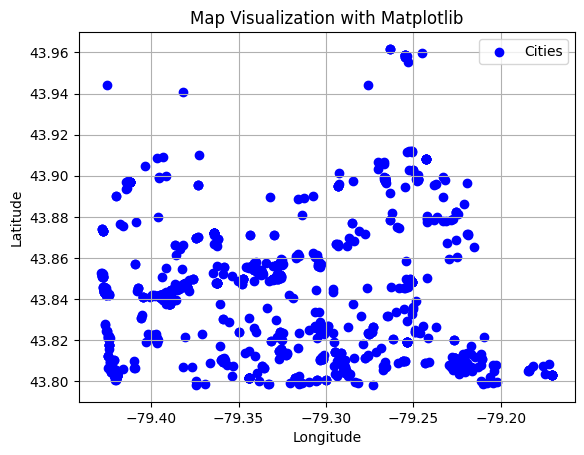

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_target.columns = df_target.columns.str.strip().str.replace('\t', '')
# Create a scatter plot of latitude and longitude from the DataFrame
plt.scatter(df_target['Property.Address.Longitude'], df_target['Property.Address.Latitude'], c='blue', marker='o', label='Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map Visualization with Matplotlib')
plt.legend()
plt.grid(True)
plt.show()


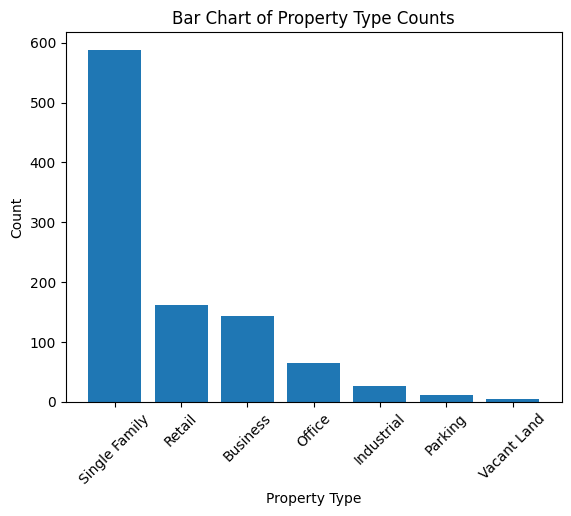

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'type' and count occurrences
type_counts = df_target['Property.Type'].value_counts()

# Create a bar chart
plt.bar(type_counts.index, type_counts)
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.title('Bar Chart of Property Type Counts')

# Rotate the x-labels by 45 degrees for better readability
plt.xticks(rotation=45)

plt.show()


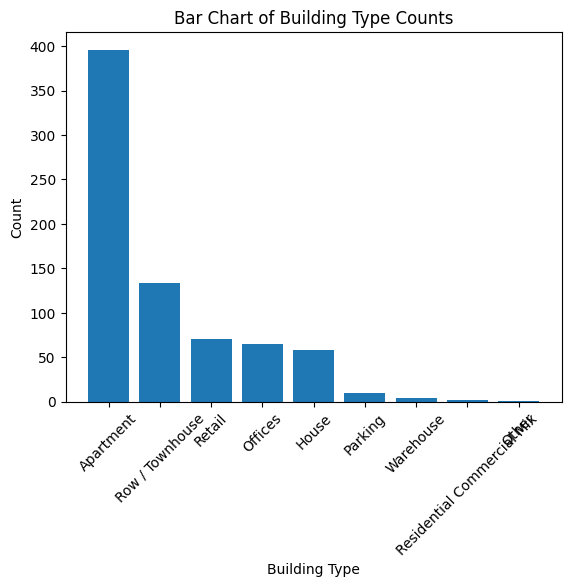

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'type' and count occurrences
type_counts = df_target['Building.Type'].value_counts()

# Create a bar chart
plt.bar(type_counts.index, type_counts)
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.title('Bar Chart of Building Type Counts')

# Rotate the x-labels by 45 degrees for better readability
plt.xticks(rotation=45)

plt.show()


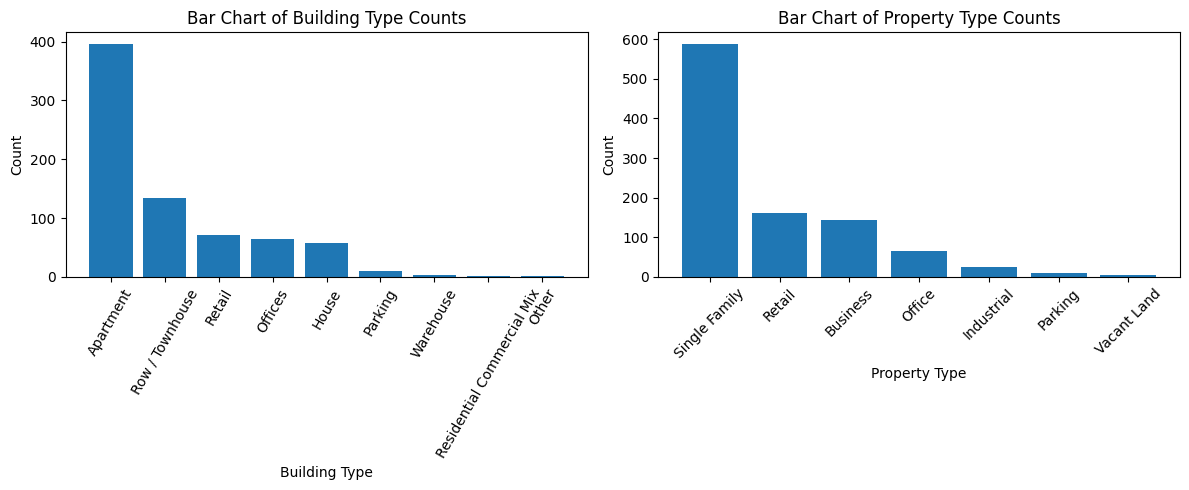

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new figure with two subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first bar chart in the first subplot
type_counts1 = df_target['Property.Type'].value_counts()
ax1.bar(type_counts1.index, type_counts1)
ax1.set_xlabel('Property Type')
ax1.set_ylabel('Count')
ax1.set_title('Bar Chart of Property Type Counts')
ax1.tick_params(axis='x', rotation=45)

# Plot the second bar chart in the second subplot
type_counts2 = df_target['Building.Type'].value_counts()
ax2.bar(type_counts2.index, type_counts2)
ax2.set_xlabel('Building Type')
ax2.set_ylabel('Count')
ax2.set_title('Bar Chart of Building Type Counts')
ax2.tick_params(axis='x', rotation=60)

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure with both subplots
plt.show()


In [ ]:
# Define a function to extract the city from an address
def extract_city(address):
    parts = address.split('|')
    if len(parts) == 2:
        city_part = parts[1].split(',')[0].strip()
        return city_part
    print(address)
    return "City not found"

df_target.columns = df_target.columns.str.strip().str.replace('\t', '')

# Apply the function to the 'Property.Address.AddressText' column to create a new 'City' column
df_target['City'] = df_target['Property.Address.AddressText'].apply(extract_city)

# Show the updated DataFrame
df_target.head()



Address not available
Address not available
Address not available
225 Bamburgh Circle|Unit #211|Scarborough, Ontario M1W3X9
Address not available
42 PINERY Trail|Unit #125|Scarborough, Ontario M1B6K2
Address not available


,PostalCode,Building.SizeExterior,Building.SizeInterior,Property.Price,Property.Type,Property.Address.AddressText,Property.Address.Longitude,Property.Address.Latitude,Property.PriceUnformattedValue,Building.BathroomTotal,Building.Bedrooms,Property.ParkingType,RelativeDetailsURL,PublicRemarks,Individual,Building.Type,City
0,M2H3P8,1430 sqft,1430 sqft,$1,Office,"#1-2 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108681/1-2-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",Offices,Toronto
1,M2H3P8,2116 sqft,2116 sqft,$1,Office,"#1-3 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108686/1-3-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",Offices,Toronto
2,M2H3P8,2858 sqft,2858 sqft,$1,Office,"#1-4 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108688/1-4-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",Offices,Toronto
3,M2H3P8,3935 sqft,3935 sqft,$1,Office,"#1-5 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108689/1-5-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",Offices,Toronto
4,M2H3P8,4706 sqft,4706 sqft,$1,Office,"#1-6 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108691/1-6-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...",Offices,Toronto


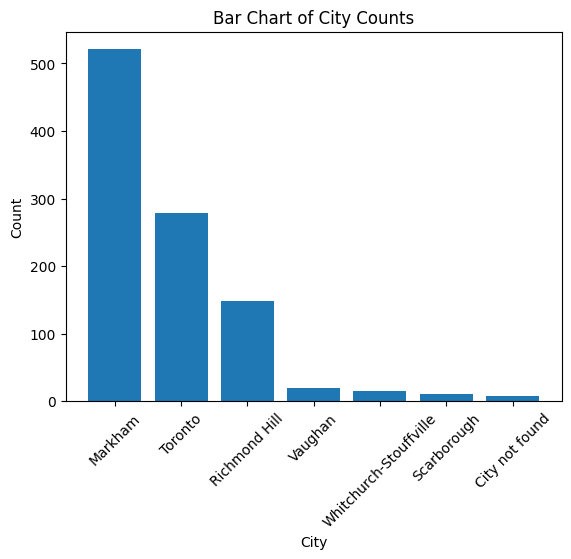

In [ ]:
# Group by 'city' and count occurrences
type_counts = df_target['City'].value_counts()

# Create a bar chart
plt.bar(type_counts.index, type_counts)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Bar Chart of City Counts')

# Rotate the x-labels by 45 degrees for better readability
plt.xticks(rotation=45)

plt.show()


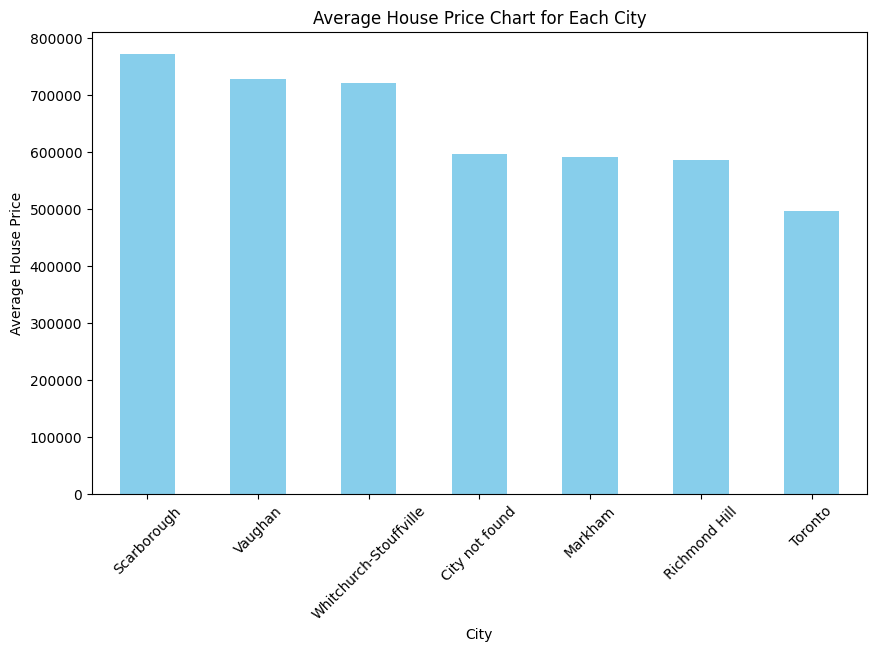

In [ ]:
# Calculate the average house prices for each city
average_prices = df_target.groupby('City')['Property.PriceUnformattedValue'].mean()
average_prices = average_prices.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='skyblue')
plt.xlabel('City')
plt.ylabel('Average House Price')
plt.title('Average House Price Chart for Each City')

# Rotate the x-labels by 45 degrees for better readability
plt.xticks(rotation=45)

plt.show()




In [ ]:
def extract_names(individual_data):
    names = []
    individuals = eval(individual_data)
    for item in individuals:
        if "Name" in item:
            names.append(item["Name"])
    return names

# Apply the function to create a new 'Names' column
df_target['Agency Name'] = df_target['Individual'].apply(extract_names)

# Print the updated DataFrame
df_target.head()



,PostalCode,Building.SizeExterior,Building.SizeInterior,Property.Price,Property.Type,Building.Type,Property.Address.AddressText,Property.Address.Longitude,Property.Address.Latitude,Property.PriceUnformattedValue,Building.BathroomTotal,Building.Bedrooms,Property.ParkingType,RelativeDetailsURL,PublicRemarks,Individual,Names,Agency Name
0,M2H3P8,1430 sqft,1430 sqft,$1,Office,Offices,"#1-2 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108681/1-2-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...","[REID BETHELL, CONOR CHARLES BETHELL]","[REID BETHELL, CONOR CHARLES BETHELL]"
1,M2H3P8,2116 sqft,2116 sqft,$1,Office,Offices,"#1-3 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108686/1-3-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...","[REID BETHELL, CONOR CHARLES BETHELL]","[REID BETHELL, CONOR CHARLES BETHELL]"
2,M2H3P8,2858 sqft,2858 sqft,$1,Office,Offices,"#1-4 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108688/1-4-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...","[REID BETHELL, CONOR CHARLES BETHELL]","[REID BETHELL, CONOR CHARLES BETHELL]"
3,M2H3P8,3935 sqft,3935 sqft,$1,Office,Offices,"#1-5 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108689/1-5-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...","[REID BETHELL, CONOR CHARLES BETHELL]","[REID BETHELL, CONOR CHARLES BETHELL]"
4,M2H3P8,4706 sqft,4706 sqft,$1,Office,Offices,"#1-6 -105 GORDON BAKER RD|Toronto, Ontario M2H3P8",-79.343959,43.801673,1,NaN,NaN,NaN,/real-estate/26108691/1-6-105-gordon-baker-rd-...,"A Unique Chance For Ownership At 95 Corporate,...","[{'IndividualID': 2072509, 'Name': 'REID BETHE...","[REID BETHELL, CONOR CHARLES BETHELL]","[REID BETHELL, CONOR CHARLES BETHELL]"


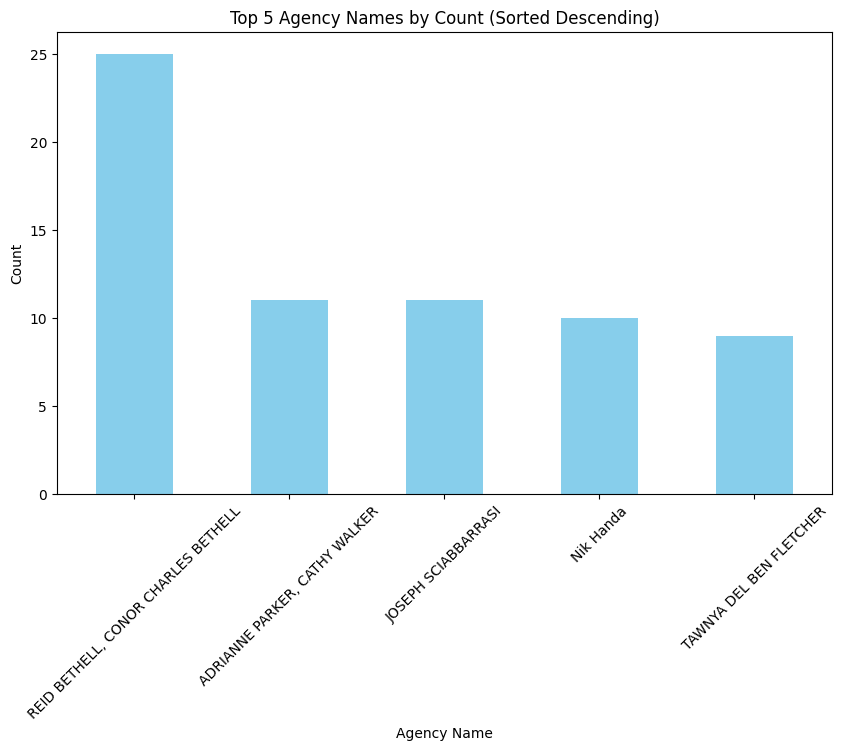

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the 'Agency Name' column if it contains lists
df_target['Agency Name'] = df_target['Agency Name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Group by 'Agency Name' and count occurrences
type_counts = df_target['Agency Name'].value_counts()

# Sort the counts in descending order and select the top 5 values
top_5_type_counts = type_counts.sort_values(ascending=False).head(5)

# Create a bar chart for the top 5 values
plt.figure(figsize=(10, 6))
top_5_type_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Agency Name')
plt.ylabel('Count')
plt.title('Top 5 Agency Names by Count (Sorted Descending)')

# Rotate the x-labels by 45 degrees for better readability
plt.xticks(rotation=45)

plt.show()

